In [1]:
from pathlib import Path
import warnings
import gc
import os
import re

from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from transformers import TrainingArguments, Trainer
from sklearn.metrics import roc_auc_score
from datasets import Dataset, ClassLabel
from easydict import EasyDict as edict
from imutils.paths import list_files
import matplotlib.pyplot as plt
import librosa.display as ldp
import IPython.display as idp
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import torchaudio
import evaluate
import librosa
import torch

warnings.filterwarnings('ignore')
tqdm.pandas()

/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gc.collect()
torch.cuda.empty_cache()

In [3]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-4])
DATA_PATH = f'{ROOT_PATH}/Datasets/MusicNet'

args = {}

## RATE_HZ * SECONDS 해서 최대 음성 길이 설정
args['max_length'] = 1600000
args['base_model'] = 'facebook/wav2vec2-base-960h'
args['n_samples']  = 3

## 리샘플링 해줄 Hz
args['rate_hz']      = 16000
args['device']       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args['seed']         = 99

args['lr']           = 5e-6
args['batch_size']   = 1
args['warmup_steps'] = 50
args['weight_decay'] = 0.02
args['epochs']       = 15
args['model_name']   = 'classical_composer_classifier'


args = edict(args)

In [4]:
def display_wav(df, composer, n_samples = 3):
    
    composed_music = df[df.composer == composer]
    rand_idx       = np.random.randint(0, len(composed_music), n_samples)
    _, axes        = plt.subplots(n_samples, 1, figsize = (18, n_samples * 3))
    prev_idx       = -1
    
    for idx, ax in zip(rand_idx, axes):
        
        file_path   = composed_music['file'][idx]
        composition = composed_music['composition'][idx] 
        wav,     _  = librosa.core.load(file_path)
        
        prev_idx = idx
        
        ax.plot(wav)
        ax.set_ylim([-1, 1])
        ax.set_title(f'{composer} - {composition}')
    
    
    
def get_transform_audio(file):
    
    audio, rate = torchaudio.load(str(file))
    
    transform   = torchaudio.transforms.Resample(rate, args.rate_hz)
    audio       = transform(audio).squeeze(0).numpy()
    audio       = audio[:args.max_length]

    return audio


def preprocess(batch):
    
    inputs = feature_extractor(batch['audio'], sampling_rate = args.rate_hz,
                               max_length = args.max_length, truncation = True)
    inputs['input_values'] = inputs['input_values'][0]
    
    return inputs


def compute_metrics(eval_pred):
    
    pred      = eval_pred.predictions
    pred      = np.exp(pred) / np.exp(pred).sum(axis = 1, keepdims = True)
    label_ids = eval_pred.label_ids
    roc_auc   = roc_auc_score(label_ids, pred, average = 'macro', multi_class = 'ovr')
    acc_score = accuracy.compute(predictions = pred.argmax(axis = 1), references = label_ids)['accuracy']
    
    return {'roc_auc' : roc_auc, 'accuracy' : acc_score}
    

In [5]:
df        = pd.read_csv(f'{DATA_PATH}/musicnet_metadata.csv')
df.sample(5).T

,35,272,322,205,307
id,1793,2522,2627,2381,2593
composer,Mozart,Beethoven,Beethoven,Beethoven,Beethoven
composition,String Quartet No 19 in C major,Cello Sonata No. 3 in A major,Violin Sonata No 10 in G major,String Quartet No 13 in B-flat major,Piano Sonata No 18 in E-flat major
movement,2. Andante cantabile,2. Scherzo. Allegro molto,2. Adagio espressivo,"1. Adagio, ma non troppo - Allegro",1. Allegro
ensemble,String Quartet,Accompanied Cello,Accompanied Violin,String Quartet,Solo Piano
source,European Archive,Hielko Ubels,Irrera Brothers,European Archive,Paul Pitman
transcriber,Gunter R. Findenegg,suzumedia,suzumedia,suzumedia,piano-midi.de
catalog_name,K465,OP69,OP96,OP130,OP31NO3
seconds,504,363,323,560,512


In [6]:
print(df.composer.value_counts())
df.id = df.id.astype(str)
df.info()

Beethoven    157
Bach          67
Schubert      30
Mozart        24
Brahms        24
Cambini        9
Dvorak         8
Faure          4
Ravel          4
Haydn          3
Name: composer, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            330 non-null    object
 1   composer      330 non-null    object
 2   composition   330 non-null    object
 3   movement      330 non-null    object
 4   ensemble      330 non-null    object
 5   source        330 non-null    object
 6   transcriber   330 non-null    object
 7   catalog_name  330 non-null    object
 8   seconds       330 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 23.3+ KB


In [7]:
composers = set(df.composer)
lb2idx    = {lb  : idx for idx,  lb in enumerate(composers)}
idx2lb    = {idx : lb  for lb , idx in lb2idx.items()}

lb2idx, idx2lb

({'Haydn': 0,
  'Ravel': 1,
  'Brahms': 2,
  'Cambini': 3,
  'Bach': 4,
  'Dvorak': 5,
  'Faure': 6,
  'Mozart': 7,
  'Schubert': 8,
  'Beethoven': 9},
 {0: 'Haydn',
  1: 'Ravel',
  2: 'Brahms',
  3: 'Cambini',
  4: 'Bach',
  5: 'Dvorak',
  6: 'Faure',
  7: 'Mozart',
  8: 'Schubert',
  9: 'Beethoven'})

In [8]:
wav_paths   = sorted(list_files(f'{DATA_PATH}/musicnet/musicnet'))
wav_paths   = [wav for wav in wav_paths if wav.split('.')[1] == 'wav']
sample_list = [re.match(r'(\d+)', Path(path).stem).group(0) for path in wav_paths]

df_          = pd.DataFrame()
df_['file']  = wav_paths
df_['id']    = sample_list

df_

,file,id
0,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,1759
1,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,1819
2,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,2106
3,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,2191
4,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,2298
...,...,...
325,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,2632
326,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,2633
327,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,2659
328,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,2677


In [9]:
## 파일 경로 df랑 원본 df랑 id값으로 join
df_          = df_.set_index('id').join(df.set_index('id'), how = 'inner')
df_          = df_[df_.composer.isin(composers)]
df_['label'] = df_.composer.apply(lambda x: lb2idx[x])
df_.sample(5).T

id,2608,2398,2346,2157,2218
file,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,/home/jovyan/dove/projects/BACKUP/misc/Dataset...
composer,Beethoven,Beethoven,Beethoven,Brahms,Bach
composition,Piano Sonata No 16 in G major,Violin Sonata No 9 in A major,Piano Sonata No 14 in C-sharp minor,String Sextet No 1 in B-flat major,Cello Suite 3
movement,"3. Rondo, allegretto - presto",2. Andante con variazioni,1. Adagio sostenuto,4. Rondo: Poco Allegretto e grazioso,2. Allemande
ensemble,Solo Piano,Accompanied Violin,Solo Piano,String Sextet,Solo Cello
source,Paul Pitman,Edward Auer,Paul Pitman,Carl Banner,European Archive
transcriber,piano-midi.de,Darren L. Slider,piano-midi.de,harfesoft.de,David J. Grossman
catalog_name,OP31NO1,OP47,OP27NO2,OP18,BWV1009
seconds,390,910,335,661,199
label,9,9,9,2,4


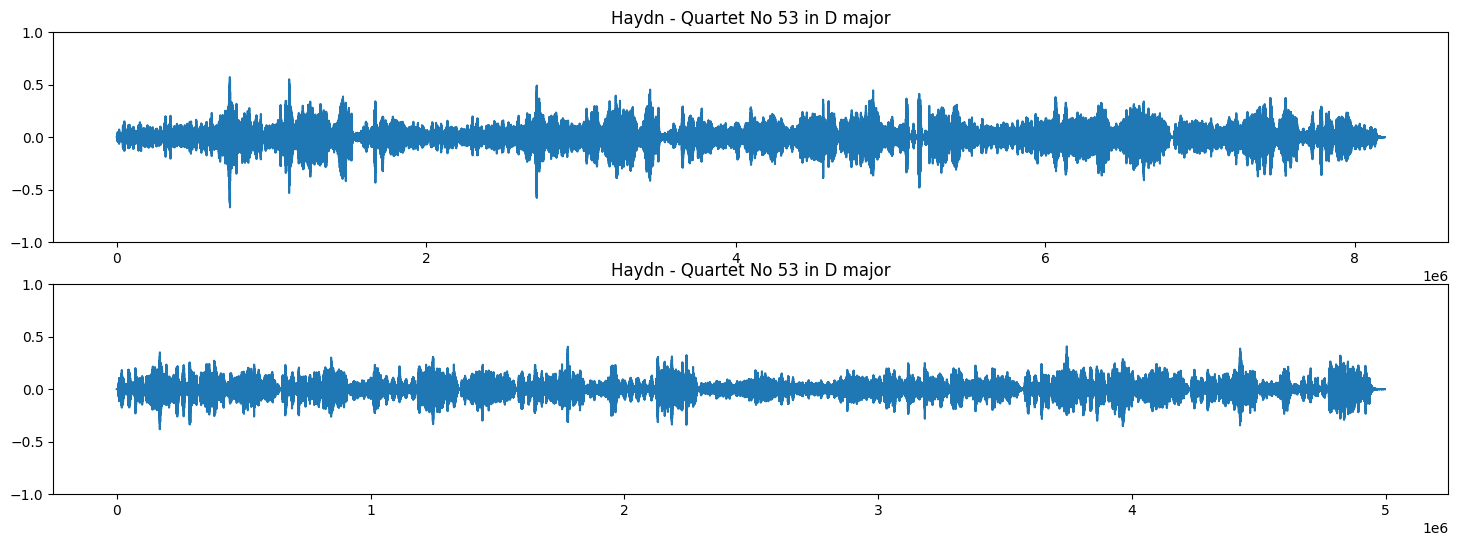

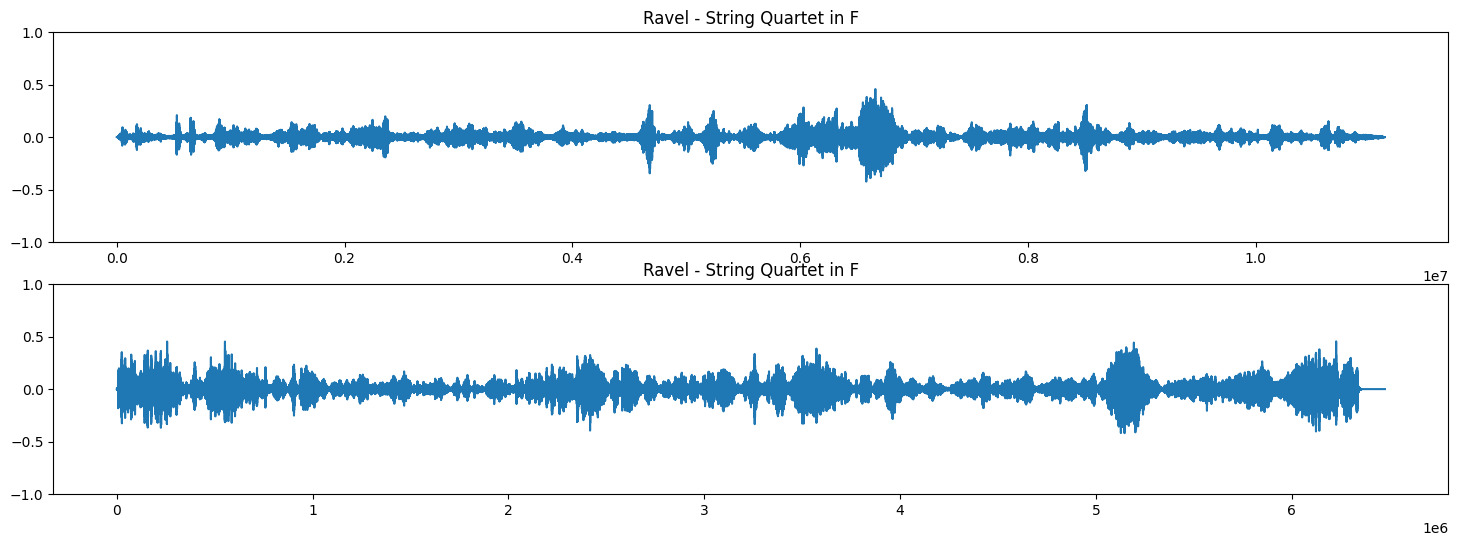

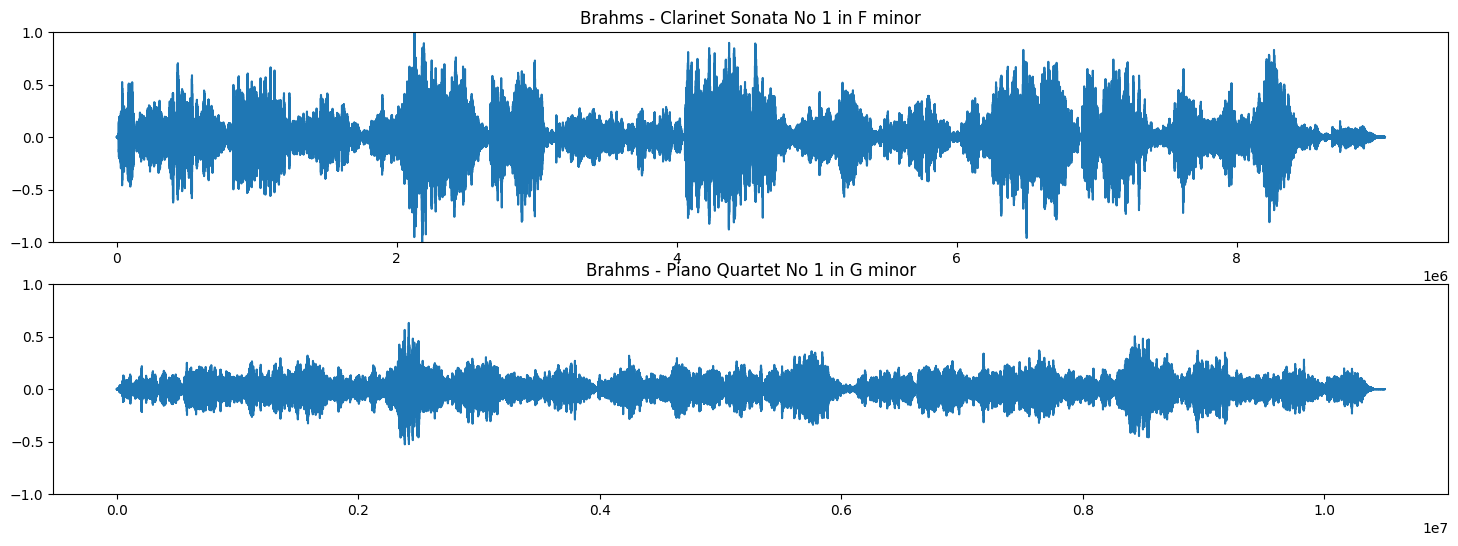

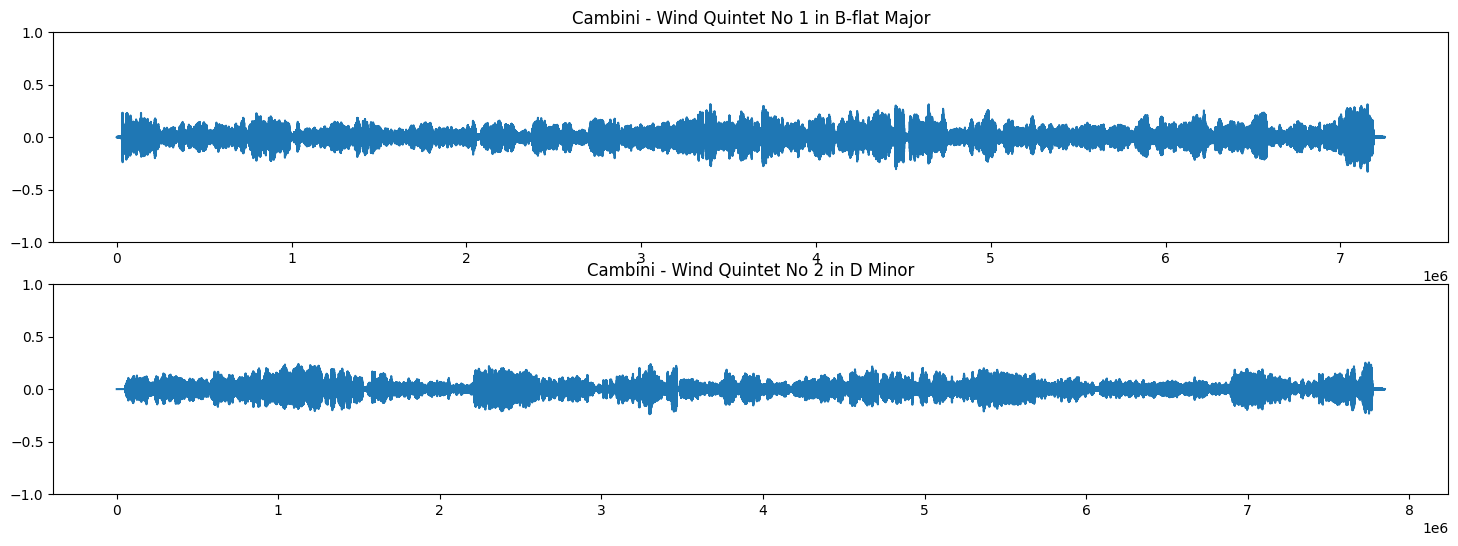

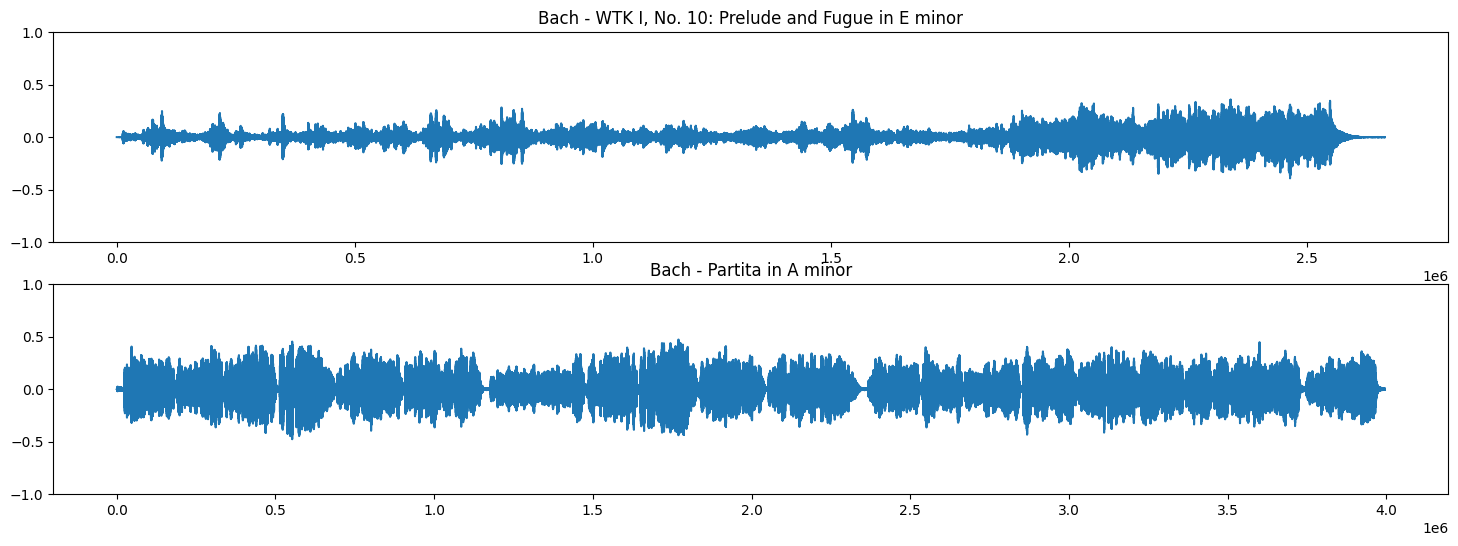

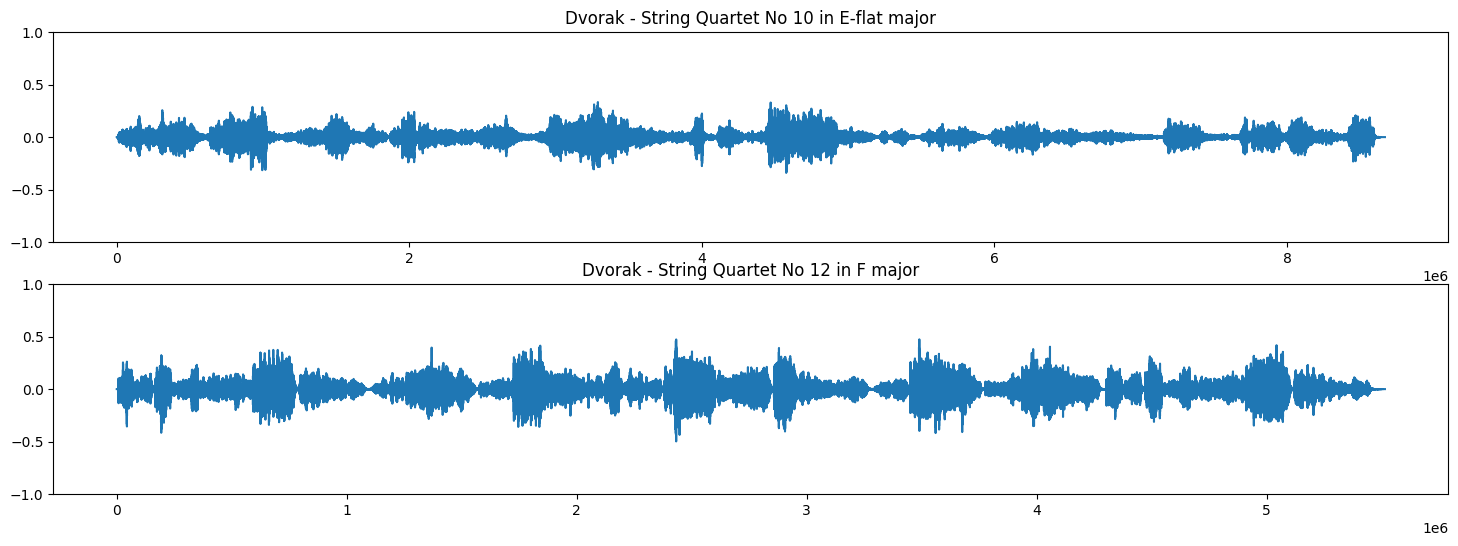

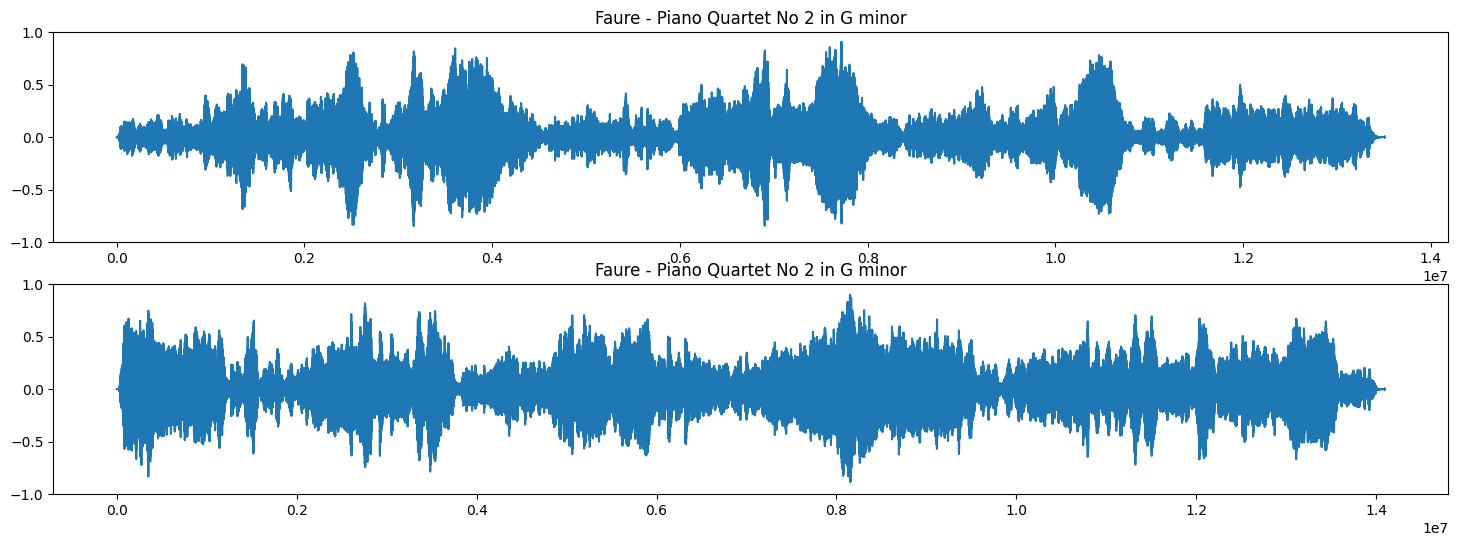

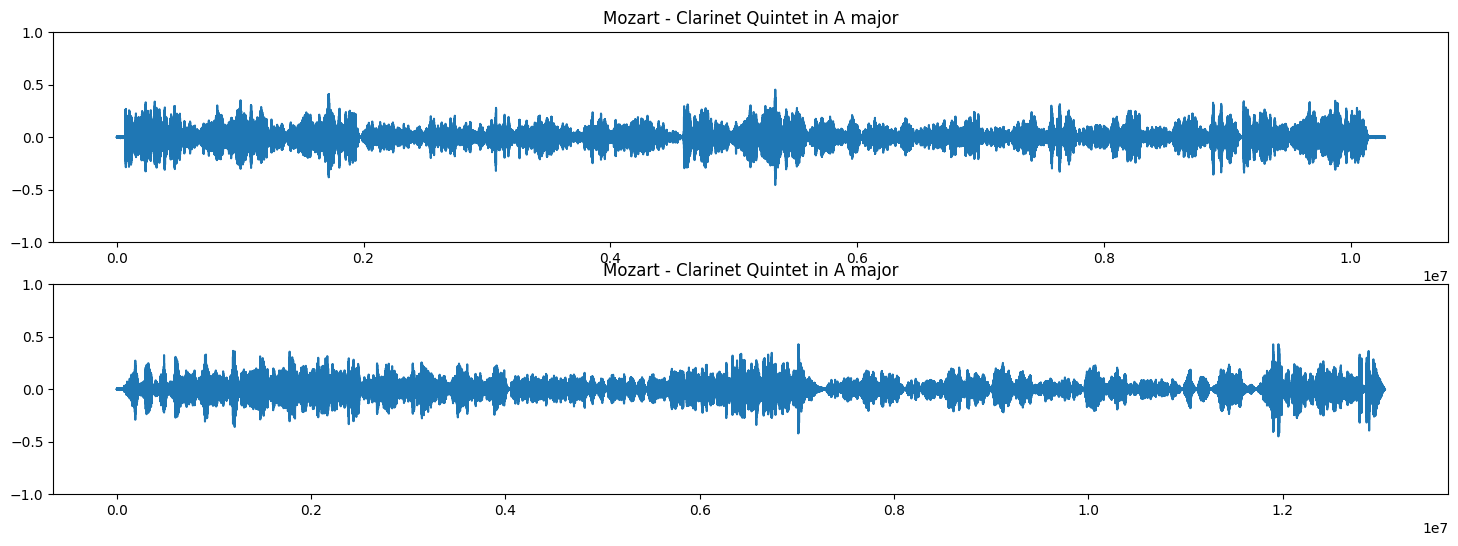

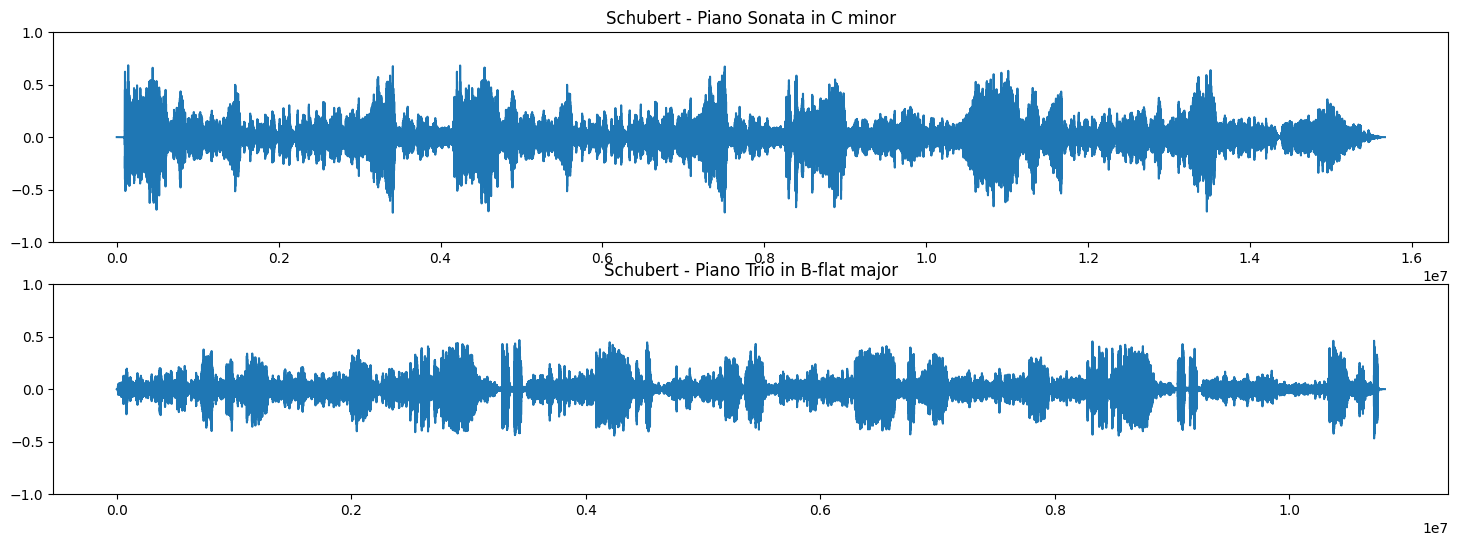

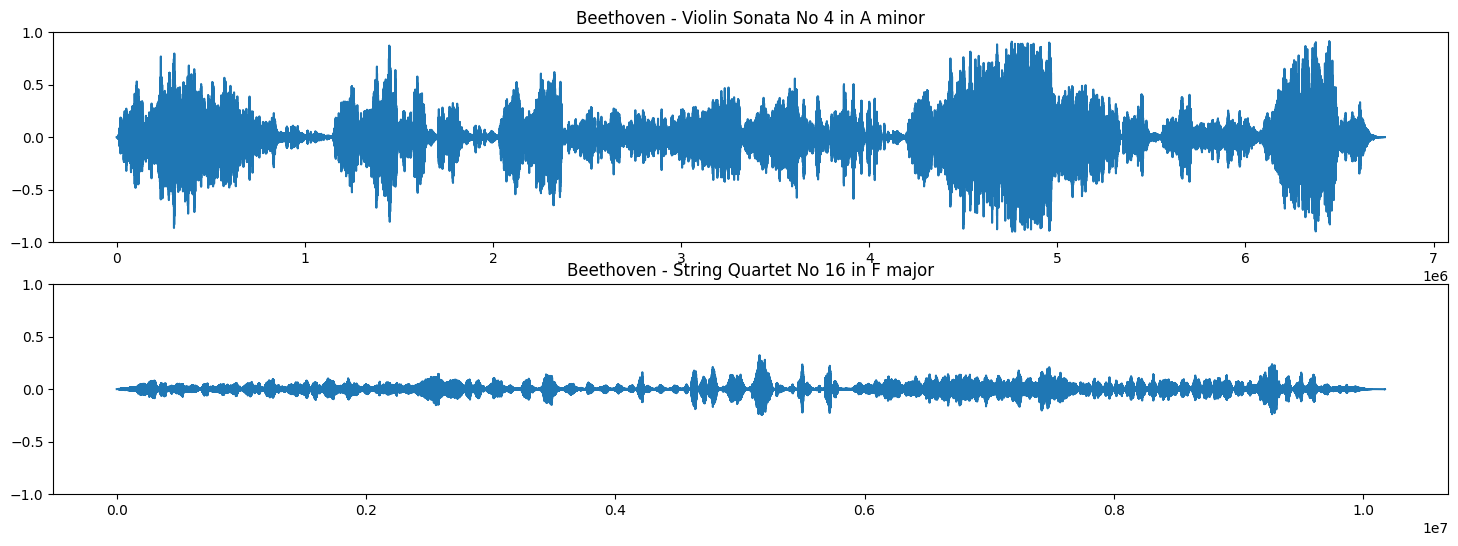

In [10]:
for composer in lb2idx.keys():
    display_wav(df_, composer, n_samples = 2)

In [11]:
selected_cols = ['file', 'label', 'composer']
df_           = df_[selected_cols]
df_['audio']  = df_.file.progress_apply(get_transform_audio)

df_.sample(5).T

100%|██████████| 330/330 [01:06<00:00,  4.96it/s]


id,2195,2366,2538,2550,2567
file,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,/home/jovyan/dove/projects/BACKUP/misc/Dataset...,/home/jovyan/dove/projects/BACKUP/misc/Dataset...
label,4,9,9,9,9
composer,Bach,Beethoven,Beethoven,Beethoven,Beethoven
audio,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
## 래이블 불균형으로 인해 레이블이 많은 데이터는 수를 줄이고,
## 래이블이 적은 데이터는 수를 늘림.
rus              = RandomUnderSampler(random_state = args.seed, sampling_strategy = 'majority')
y                = df_[['label']]
df_              = df_.drop(['label'], axis = 1)
df_, resampled_y = rus.fit_resample(df_, y)
df_['label']     = resampled_y

print(df_.label.value_counts())
del y, resampled_y

4    67
8    30
2    24
7    24
3     9
5     8
1     4
6     4
0     3
9     3
Name: label, dtype: int64


In [13]:
y, df_           = df_[['label']], df_.drop(['label'], axis = 1)
ros              = RandomOverSampler(random_state = args.seed)
df_, resampled_y = ros.fit_resample(df_, y)
df_['label']     = resampled_y
print(df_.label.value_counts())
del y, resampled_y
gc.collect()

0    67
1    67
2    67
3    67
4    67
5    67
6    67
7    67
8    67
9    67
Name: label, dtype: int64


54463

In [14]:
df_ = df_.drop(['file', 'composer'], axis = 1)
df_.sample(5).T

,403,472,356,450,18
audio,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-7.2057816e-07, 1.0818043e-05, 1.1025166e-06,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6890738e-08, ..."
label,3,6,3,5,2


In [15]:
dataset = Dataset.from_pandas(df_)
dataset = dataset.train_test_split(test_size = 0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 536
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 134
    })
})

In [16]:
feature_extractor     = AutoFeatureExtractor.from_pretrained(args.base_model)
model                 = AutoModelForAudioClassification.from_pretrained(args.base_model, num_labels = len(composers))
model.config.id2label = idx2lb

model.num_parameters(only_trainable = True)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['projector.weight', 'wav2vec2.masked_spec_embed', 'classifier.weight', 'projector.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


94571146

In [17]:
dataset['train'] = dataset['train'].map(preprocess, remove_columns = 'audio', batched = False)
dataset['test']  =  dataset['test'].map(preprocess, remove_columns = 'audio', batched = False)

gc.collect()

Map: 100%|██████████| 134/134 [01:30<00:00,  1.48 examples/s]


46

In [18]:
os.makedirs(f'{ROOT_PATH}/logs', exist_ok = True)
accuracy = evaluate.load('accuracy')

training_args = TrainingArguments(
                    output_dir                  =      args.model_name,
                    logging_dir                 =  f'{ROOT_PATH}/logs',
                    num_train_epochs            =          args.epochs,
                    per_device_train_batch_size =      args.batch_size,
                    per_device_eval_batch_size  =      args.batch_size,
                    learning_rate               =              args.lr,
                    logging_strategy            =              'steps',
                    logging_first_step          =                 True,
                    load_best_model_at_end      =                 True,
                    logging_steps               =                    1,
                    evaluation_strategy         =              'epoch',
                    warmup_steps                =    args.warmup_steps,
                    weight_decay                =    args.weight_decay,
                    gradient_accumulation_steps =                    4,
                    gradient_checkpointing      =                 True,
                    eval_steps                  =                    1,
                    save_strategy               =              'epoch',
                    save_total_limit            =                    1,
                    report_to                   =             'mlflow'
                )

In [19]:
trainer = Trainer(
            model            =             model,
            args             =     training_args,
            train_dataset    =  dataset['train'],
            eval_dataset     =   dataset['test'],
            tokenizer        = feature_extractor,
            compute_metrics  =   compute_metrics
        )

In [20]:
trainer.evaluate()

{'eval_loss': 2.304084539413452,
 'eval_roc_auc': 0.5283324858655379,
 'eval_accuracy': 0.04477611940298507,
 'eval_runtime': 114.9613,
 'eval_samples_per_second': 1.166,
 'eval_steps_per_second': 0.148}

In [ ]:
trainer.train()